In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Install dependencies
!pip install yfinance pandas matplotlib seaborn xgboost scikit-learn  --quiet

# Loading Inflation Data
---

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import pandas as pd

inflation_data = pd.read_excel("Us Inflation rate.xlsx")

# Melt the dataframe to convert month columns into rows
inflation_melted = inflation_data.melt(id_vars=["Year"], var_name="Month", value_name="Inflation Rate")

# Remove rows with 'Ave' in Month column and any rows with NaN in 'Year' or 'Inflation Rate'
inflation_melted = inflation_melted[inflation_melted['Month'] != 'Ave']
inflation_melted = inflation_melted.dropna(subset=['Year', 'Inflation Rate'])

# Convert 'Year' and 'Month' into a datetime index (last day of each month)
inflation_melted['Date'] = pd.to_datetime(inflation_melted['Year'].astype(int).astype(str) + '-' + inflation_melted['Month'] + '-1')
inflation_melted['Date'] = inflation_melted['Date'] + pd.offsets.MonthEnd(0)

# Set the 'Date' column as the index and drop unnecessary columns
inflation_melted = inflation_melted.set_index('Date')
inflation_melted = inflation_melted.drop(columns=['Year', 'Month'])

# Sort the data by date
inflation_melted = inflation_melted.sort_index()

# Display the first few rows of the transformed data
inflation_melted.head()

,Inflation Rate
Date,
2000-01-31,2.7
2000-02-29,3.2
2000-03-31,3.8
2000-04-30,3.1
2000-05-31,3.2


# Load and prepare the mutual fund data
---

In [5]:
import yfinance as  yf
import pandas as pd

# Set a mutual fund using ticker symbol
ticker_symbol = "VFINX"

# Fetch mutual fund data
mutual_fund = yf.Ticker(ticker_symbol)
# Get past data of 15yrs
history = mutual_fund.history(period='15y')

#  Data in tabular format
data = pd.DataFrame(history)

# Make index dtype to date-time
data.index = pd.to_datetime(data.index)

# Daily close data
daily_data = data[['Close']]

# Resample the data to monthly frequency and take the last value of each month
monthly_data = daily_data.resample('M').last()

# Feature Engineering
---

In [6]:
# Calculating Percentage Increase from Previous Close
monthly_data['previous_close'] = monthly_data['Close'].shift(1)
monthly_data.dropna(inplace=True)
monthly_data['percentage_increase_from_previous_close'] = (monthly_data['Close'] - monthly_data['previous_close'])/monthly_data['previous_close']*100

In [7]:
def calculate_rolling_average(close_values: list[float], period: int) -> list[float]:
    """
    Calculate the rolling average of close values over a specified period.
    Adjustments are made to keep the input and output dimension same. Careful
    consideration is also given not take the current value in calculation. That is
    if the rolling of avg for ith position is calculated, then only values till i-1
    is considered.

    Parameters:
    - close_values (List[float]): List of close price values.
    - period (int): The rolling window period for calculating the average.

    Returns:
    - List[float]: List of rolling average values.
    """

    rolling_average:list[float] = []

    for i in range(len(close_values)):

      if i == 0:
        # As there are no prev values considering the same value as avg
        rolling_average.append(close_values[i])

      elif i < period:
        # If window size is less than period cal avg based on window size
        window = close_values[:i]
        average = sum(window) / len(window)
        rolling_average.append(average)

      else:
          window = close_values[i - period + 1:i]
          average = sum(window) / len(window)
          rolling_average.append(average)

    return rolling_average

In [8]:
def calculate_volatility(close_values: list[float], period: int) -> list[float]:
  """
  Calculate the rolling volatility of close values over a specified period.

  Parameters:
  - close_values (List[float]): List of close price values.
  - period (int): The rolling window period for calculating volatility.

  Returns:
  - List[float]: List of rolling volatility values.
  """
  volatility: list[float] = []

  for i in range(len(close_values)):
    if i == 0:
      # If there are no previous values, set volatility to 0
      volatility.append(0.0)

    elif i < period:
      # If the window size is less than the period, calculate volatility based on the window size
      window = close_values[:i]

      if len(window) == 1:
        # If there's only one value, volatility can't be calculated, so set it to 0
        volatility.append(0.0)

      else:
        # Volatility is the percentage change between the first and last value in the window
        change = (window[-1] - window[0]) / window[0]
        volatility.append(change)

    else:
      # Calculate volatility over the specified period
      window = close_values[i - period:i]
      change = (window[-1] - window[0]) / window[0]
      volatility.append(change)

  return [100*v for v in volatility]

In [9]:
def calculate_single_period_diff(close_values: list[float]) -> pd.DataFrame:
    """
    Calculate the single-period difference of close values and create a new column for it in a DataFrame.

    Parameters:
    - close_values (List[float]): List of close price values.

    Returns:
    - pd.DataFrame: DataFrame with a 'Close_Diff' column containing the single-period differences.
    """
    # Create a DataFrame from close_values
    df = pd.DataFrame({'Close': close_values})

    # Calculate the single-period difference (percentage change) and store it in the 'Close_Diff' column
    df['Close_Diff'] = (df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)

    # Fill NaN values in the 'Close_Diff' column with 0
    df['Close_Diff'].fillna(0, inplace=True)

    return df

In [10]:
# Calculating Multiple Rolling Averages for Monthly Data
monthly_data['3_month_rolling_avg'] = calculate_rolling_average(monthly_data.Close,3)
monthly_data['6_month_rolling_avg'] = calculate_rolling_average(monthly_data.Close,6)
monthly_data['9_month_rolling_avg'] = calculate_rolling_average(monthly_data.Close,9)
monthly_data['12_month_rolling_avg'] = calculate_rolling_average(monthly_data.Close,12)

In [11]:
# Calculating Multiple Rolling Volatilities for Monthly Data
monthly_data['3_month_volatility'] = calculate_volatility(monthly_data.Close,3)
monthly_data['6_month_volatility'] = calculate_volatility(monthly_data.Close,6)
monthly_data['9_month_volatility'] = calculate_volatility(monthly_data.Close,9)
monthly_data['12_month_volatility'] = calculate_volatility(monthly_data.Close,12)

In [12]:
monthly_data[['3_month_rolling_avg','6_month_rolling_avg','9_month_rolling_avg','12_month_rolling_avg','Close']].tail(8)

,3_month_rolling_avg,6_month_rolling_avg,9_month_rolling_avg,12_month_rolling_avg,Close
Date,,,,,
2023-06-30 00:00:00-04:00,385.820007,378.290564,371.674236,367.267376,410.630005
2023-07-31 00:00:00-04:00,398.630005,385.429803,378.668777,370.333263,423.779999
2023-08-31 00:00:00-04:00,417.205002,397.036005,384.835171,375.996241,416.989990
2023-09-30 00:00:00-04:00,420.384995,404.608002,392.856602,384.072171,395.670013
2023-10-31 00:00:00-04:00,406.330002,406.740002,395.448627,387.799111,387.299988
2023-11-30 00:00:00-05:00,391.485001,406.873999,398.142502,388.967396,422.619995
2023-12-31 00:00:00-05:00,404.959991,409.271997,403.578751,395.312983,440.059998
2024-01-31 00:00:00-05:00,431.339996,412.527997,410.459999,401.233545,441.540009


In [13]:
monthly_data[['3_month_volatility','6_month_volatility','9_month_volatility','12_month_volatility','Close']].tail(8)

,3_month_volatility,6_month_volatility,9_month_volatility,12_month_volatility,Close
Date,,,,,
2023-06-30 00:00:00-04:00,1.978213,9.583244,17.819413,12.027327,410.630005
2023-07-31 00:00:00-04:00,6.654371,9.520667,15.776849,8.947809,423.779999
2023-08-31 00:00:00-04:00,9.608668,15.866347,13.174335,17.232352,416.989990
2023-09-30 00:00:00-04:00,1.548836,9.986017,18.188230,27.071141,395.670013
2023-10-31 00:00:00-04:00,-6.633155,2.768760,5.530631,11.558889,387.299988
2023-11-30 00:00:00-05:00,-7.120076,0.173288,5.892291,3.432014,422.619995
2023-12-31 00:00:00-05:00,6.811227,2.919901,11.470997,19.783952,440.059998
2024-01-31 00:00:00-05:00,13.622518,3.841616,14.298326,17.370050,441.540009


# Data Visualisation and EDA
---

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def plot_stock_prices_line(date: list[str], data: dict[str, list[float]], chart_name: str) -> None:
    """
    Create a line plot for stock prices with a specified chart title.

    Parameters:
    - date (List[str]): List of date values.
    - data (Dict[str, List[float]]): Dictionary where keys represent the line labels and values are lists of data to plot.
    - chart_name (str): Title for the line chart.

    Returns:
    - None (displays the plot)
    """
    # Create a DataFrame from the date values
    df = pd.DataFrame({'Date': date})

    # Convert 'Date' column to DateTime format and remove time zone information
    df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)
    df.set_index('Date', inplace=True)

    # Create the line plot
    plt.figure(figsize=(12, 6))
    for key, values in data.items():
      if key == 'Close Price':
        plt.plot(df.index, values, label=key, marker='o', linestyle='-')
      else:
        plt.plot(df.index, values, label=key, linestyle='-')

    # Set X-axis tick locations to yearly intervals
    plt.xticks(pd.date_range(start=min(df.index), end=max(df.index), freq='Y'), rotation=45)

    # Set the X-axis label
    plt.xlabel('Date (Year)')

    # Set the Y-axis label
    plt.ylabel('Values')

    # Add gridlines for better visualization
    plt.grid()

    # Add a legend
    plt.legend()

    # Set the plot title
    plt.title(chart_name)

    # Display the plot
    plt.tight_layout()
    plt.show()

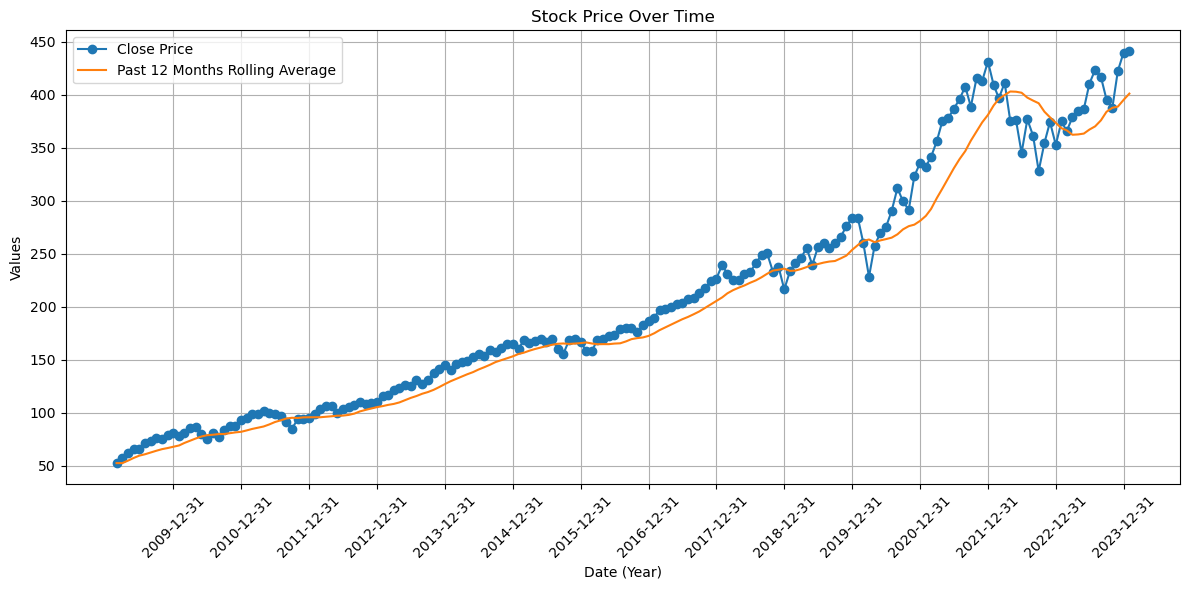

In [16]:
plot_stock_prices_line(
    date=monthly_data.index,
    data = {
        'Close Price' : monthly_data.Close,
        'Past 12 Months Rolling Average' : monthly_data['12_month_rolling_avg'],
    },
    chart_name = "Stock Price Over Time"
)

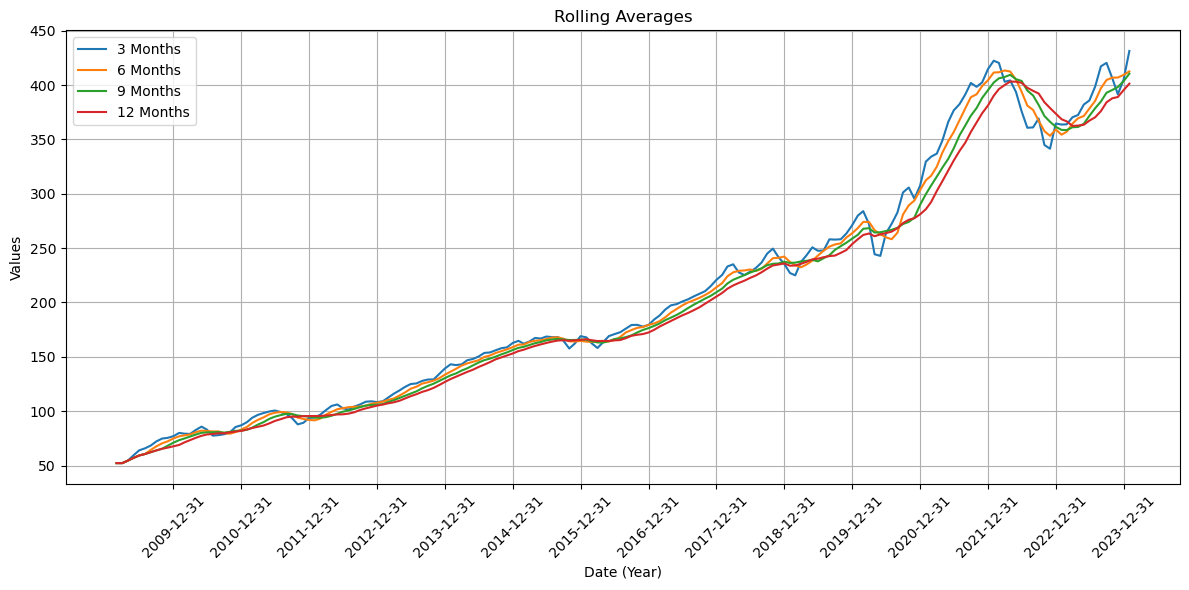

In [17]:
plot_stock_prices_line(
    date=monthly_data.index,
    data = {
        '3 Months' : monthly_data['3_month_rolling_avg'],
        '6 Months' : monthly_data['6_month_rolling_avg'],
        '9 Months' : monthly_data['9_month_rolling_avg'],
        '12 Months' : monthly_data['12_month_rolling_avg'],
    },
    chart_name = "Rolling Averages"
)

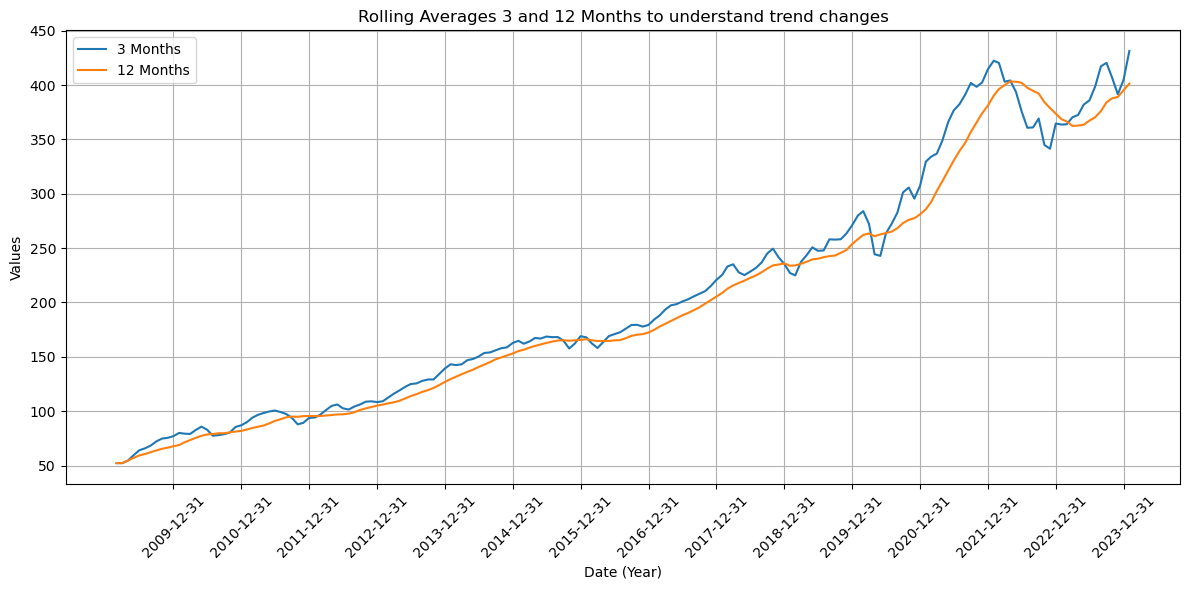

In [18]:
plot_stock_prices_line(
    date=monthly_data.index,
    data = {
        '3 Months' : monthly_data['3_month_rolling_avg'],
        '12 Months' : monthly_data['12_month_rolling_avg'],
    },
    chart_name = "Rolling Averages 3 and 12 Months to understand trend changes"
)

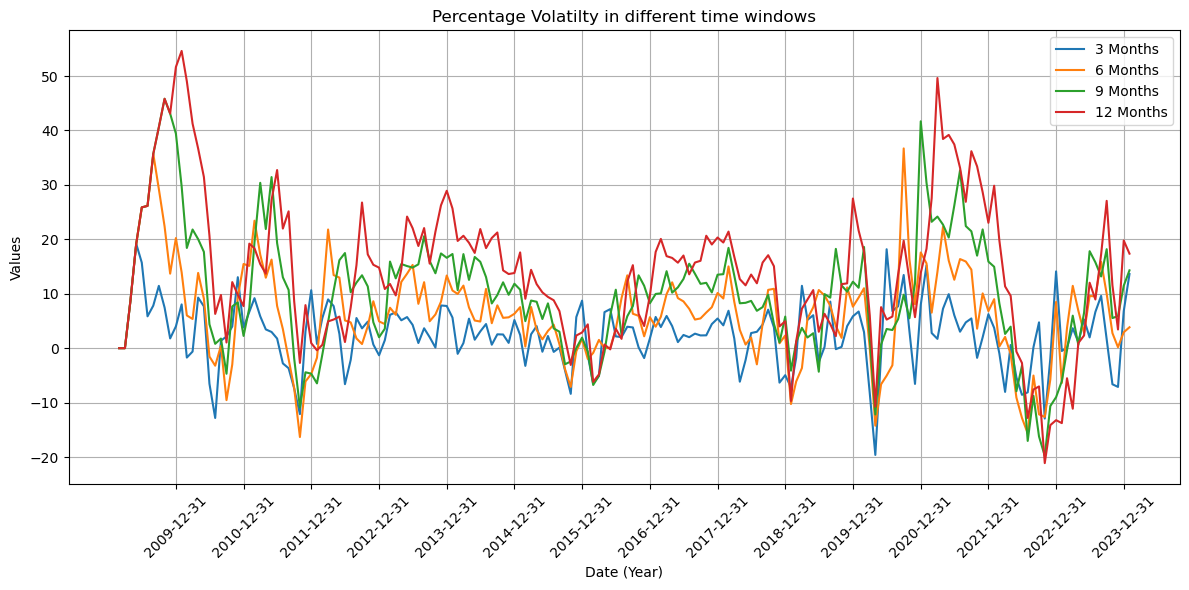

In [19]:
plot_stock_prices_line(
    date=monthly_data.index,
    data = {
        '3 Months' : monthly_data['3_month_volatility'],
        '6 Months' : monthly_data['6_month_volatility'],
        '9 Months' : monthly_data['9_month_volatility'],
        '12 Months' : monthly_data['12_month_volatility'],

    },
    chart_name = "Percentage Volatilty in different time windows"
)

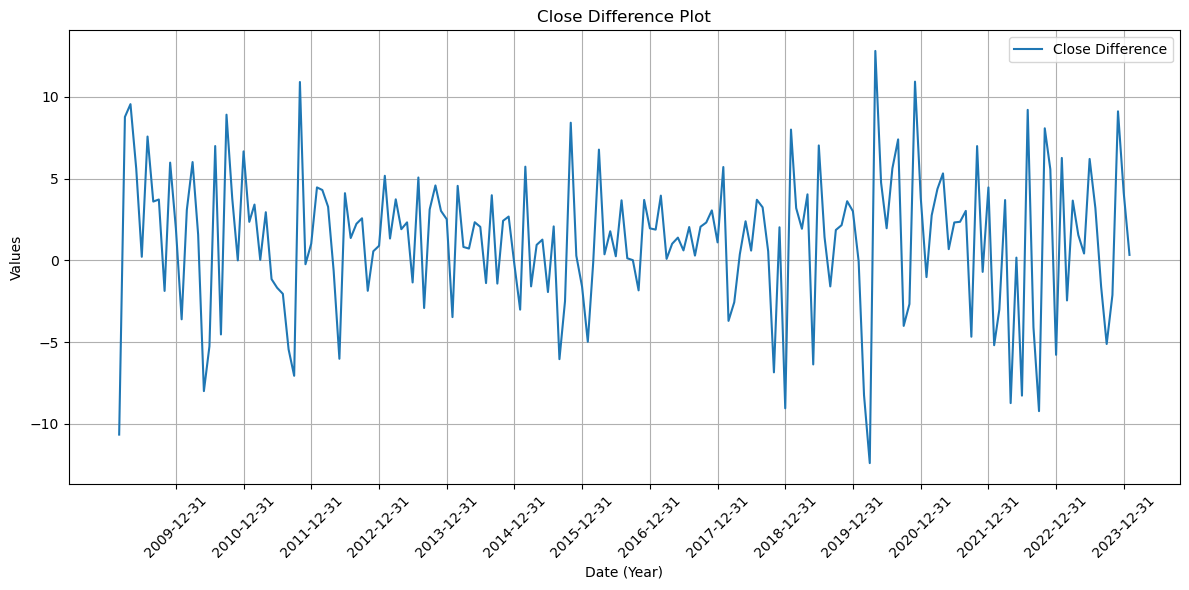

In [20]:
plot_stock_prices_line(
    date=monthly_data.index,
    data = {
        'Close Difference' : monthly_data['percentage_increase_from_previous_close']
    },
    chart_name = "Close Difference Plot"
)

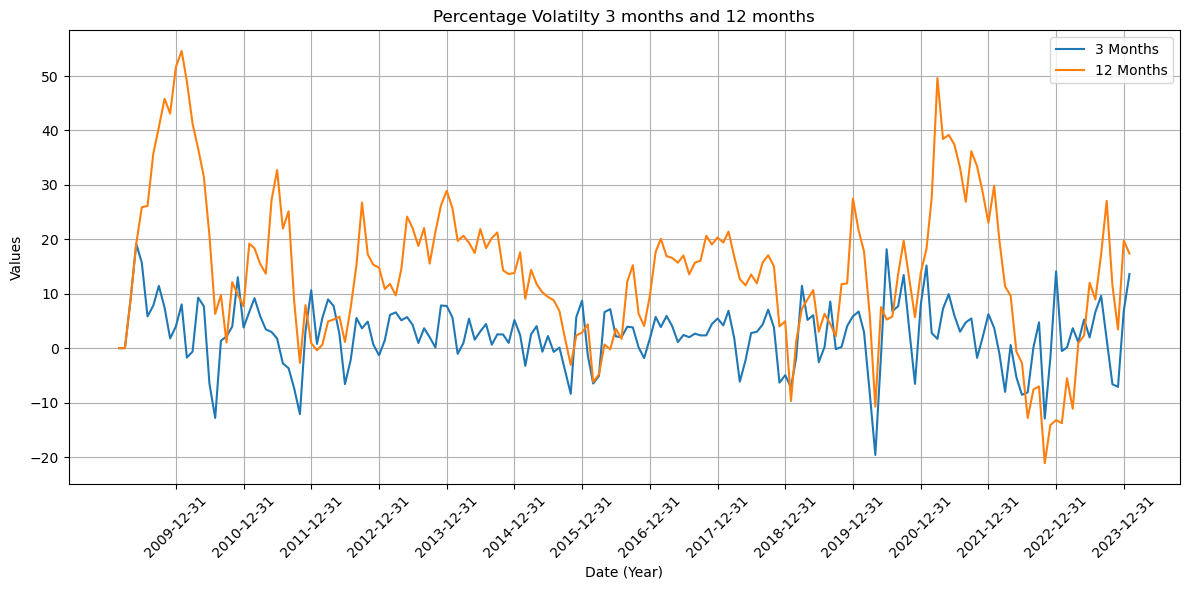

In [21]:
plot_stock_prices_line(
    date=monthly_data.index,
    data = {
        '3 Months' : monthly_data['3_month_volatility'],
        '12 Months' : monthly_data['12_month_volatility'],

    },
    chart_name = "Percentage Volatilty 3 months and 12 months"
)

In [22]:
# Resample the data to yearly frequency and take the last value of each month
yearly_data = monthly_data.resample('Y').last()

In [23]:
def plot_bars(date: list[pd.Timestamp], values: list[float], chart_title:str) -> None:
    """
    Create a bar graph of a year column extracted from dates.

    Parameters:
    - date (List[pd.Timestamp]): List of date values (pd.Timestamp objects).
    - values (List[float]): List of corresponding values.

    Returns:
    - None (displays the plot)
    """
    # Extract the year from date and create a DataFrame
    df = pd.DataFrame({'Year': [d.year for d in date], 'Values': values})

    # Create the bar graph
    plt.figure(figsize=(12, 6))
    plt.bar(df['Year'], df['Values'], width=0.8, align='center')

    # Set the X-axis label
    plt.xlabel('Year')

    # Set the Y-axis label
    plt.ylabel('Values')

    # Add gridlines for better visualization
    plt.grid()

    # Set the plot title
    plt.title(chart_title)

    # Display the plot
    plt.tight_layout()
    plt.show()


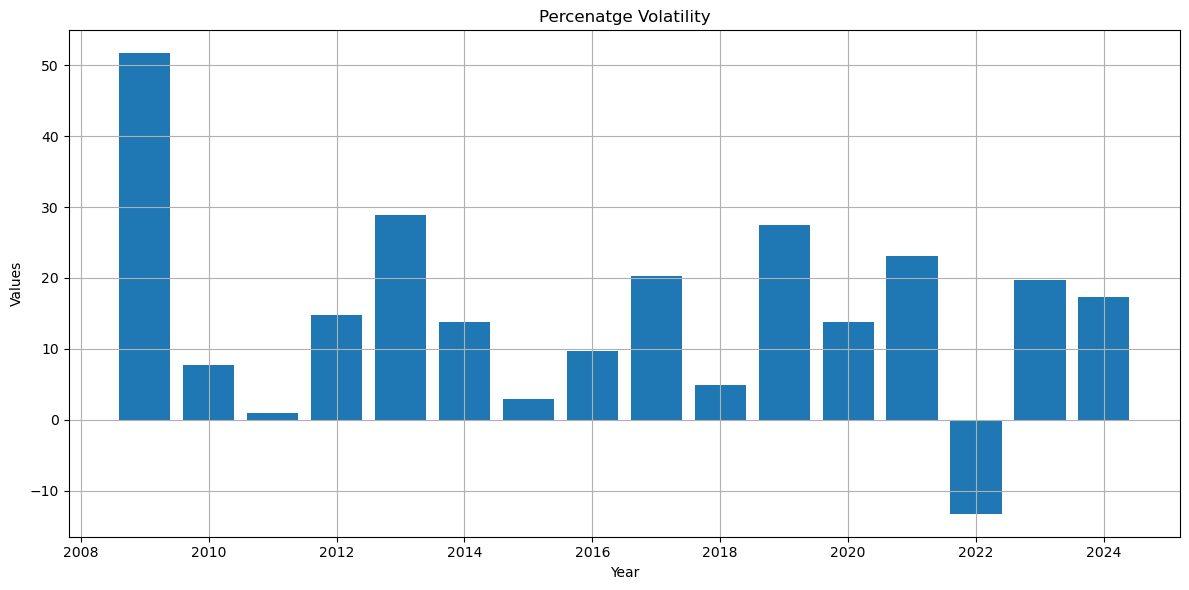

In [24]:
plot_bars(
    date = yearly_data.index,
    values = yearly_data['12_month_volatility'],
    chart_title = "Percenatge Volatility"
)

In [25]:
def whisker_plot_by_year(date, close_values):
    """
    Create a year-wise whisker plot of stock prices with date and close values.

    Parameters:
    - date (list or array-like): List or array containing date values.
    - close_values (list or array-like): List or array containing close price values.

    Returns:
    - None (displays the plot)
    """
    # Create a DataFrame from the date and close values
    df = pd.DataFrame({'Date': date, 'Close': close_values})

    # Extract the year from the date
    df['Year'] = df['Date'].dt.year

    # Create a figure and axis for the whisker plot
    plt.figure(figsize=(12, 6))

    # Create a whisker plot for each year
    sns.boxplot(x='Year', y='Close', data=df, palette='Set3')

    # Set labels and title
    plt.xlabel('Year')
    plt.ylabel('Close Value')
    plt.title('Whisker Plot of Stock Prices by Year')

    # Show the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

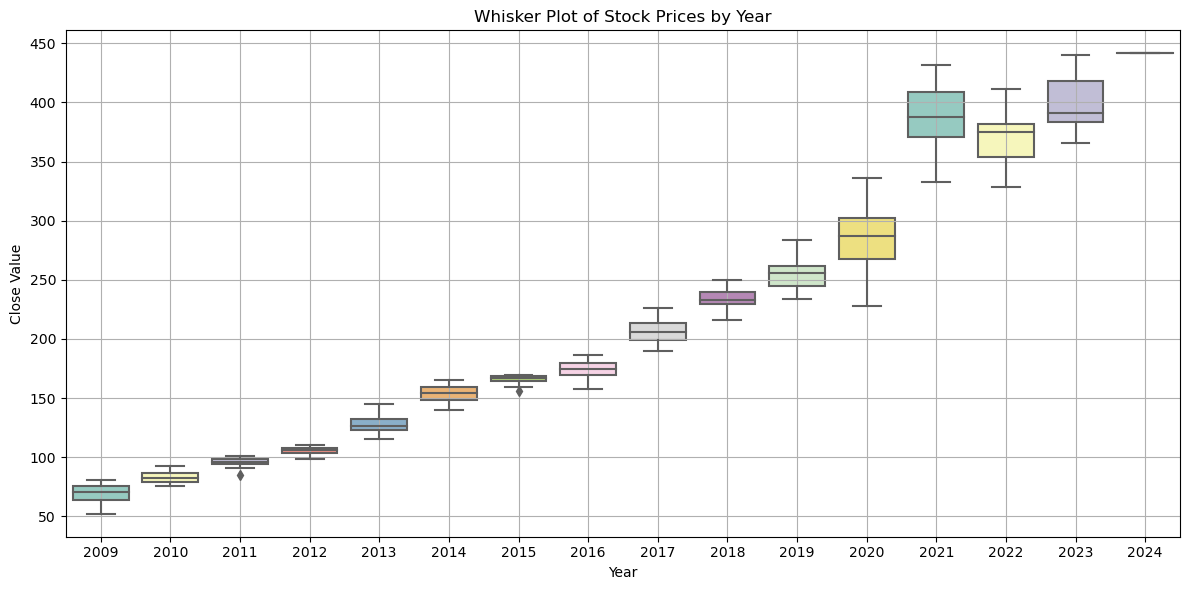

In [26]:
whisker_plot_by_year(
    date=monthly_data.index,
    close_values=monthly_data.Close
)

# Predictive modelling
---

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

In [28]:
def create_dataset(dataset: pd.DataFrame, target_column:str, window_size: int = 1) -> tuple[np.ndarray, np.ndarray]:
    """
    Create a dataset for rolling window analysis.

    This function takes a time series dataset and creates a set of features and target
    variables based on the specified rolling window size.

    Parameters:
    dataset (pd.DataFrame): The input dataset, typically a time series of values.
    window_size (int): The size of the rolling window to create features.

    Returns:
    Tuple[np.ndarray, np.ndarray]: A tuple of two numpy arrays, where the first array
                                   contains the features and the second array contains
                                   the corresponding target values.
    """

    X = dataset.drop(target_column, axis=1)
    X.reset_index(drop=True,inplace=True)
    y = dataset[target_column]
    y.reset_index(drop=True,inplace=True)

    dataX, dataY = [], []

    for i in range(len(y) - window_size - 1):

        features = list(X.iloc[i]) + list(y[i:(i + window_size)]) 
        dataX.append(features)

        target = y[i + window_size]
        dataY.append(target)

    return np.array(dataX), np.array(dataY)

In [29]:
from joblib import dump
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

def evaluate(model, model_name:str, dataset: np.ndarray, target_column:str,window_size: int = 1) -> dict[str, float]:
    """
    Evaluate the performance of a linear regression model using a rolling window approach.

    This function splits the given dataset into a training and testing set, creates a linear
    regression model, fits the model on the training data, and evaluates its performance
    using the R² metric.

    Parameters:
    - model: The linear regression model to be evaluated.
    - dataset (np.ndarray): The input dataset, typically a time series of values.
    - window_size (int): The size of the rolling window used to create features.

    Returns:
    - Dict[str, float]: A dictionary containing the evaluation metrics:
        - "train_mse" (float): Mean squared error on the training set.
        - "test_mse" (float): Mean squared error on the testing set.
        - "train_r2" (float): R² score on the training set.
        - "test_r2" (float): R² score on the testing set.
    """
    # Creating the dataset with the specified rolling window size
    X, y = create_dataset(dataset, target_column, window_size)

    # Splitting the dataset into training and testing sets
    train_size = int(len(X) * 0.70)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Fitting the model on the training data
    model.fit(X_train, y_train)
    dump(model, f'{model_name}_{window_size}.joblib')

    # Making predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Calculating the mean squared error
    mae_train_error = mean_absolute_error(y_train, train_predictions)
    mae_test_error = mean_absolute_error(y_test, test_predictions)

    # Calculating the mean absolute precision error
    mape_train_error = mean_absolute_percentage_error(y_train, train_predictions)
    mape_test_error = mean_absolute_percentage_error(y_test, test_predictions)

    # Calculating the mean absolute precision error
    mse_train_error = mean_squared_error(y_train, train_predictions)
    mse_test_error = mean_squared_error(y_test, test_predictions)

    return {
        "mae_train_error": mae_train_error,
        'mae_test_error':mae_test_error,
        "mape_train_error": mape_train_error,
        'mape_test_error':mape_test_error,
        "mse_train_error": mse_train_error,
        'mse_test_error':mse_test_error,
        "model" : model
    }

In [30]:
from sklearn.base import RegressorMixin

def create_evaluation_matrix(
    data: pd.DataFrame,
    models: dict[str, RegressorMixin],
    windows: list[int],
    target_column: str
) -> pd.DataFrame:
    """
    Create an evaluation matrix for regression models with different window sizes.

    This function evaluates the performance of regression models using a rolling window approach
    and stores the evaluation metrics in a DataFrame.

    Parameters:
    - data (pd.DataFrame): The input dataset containing features and target variable.
    - models (Dict[str, RegressorMixin]): A dictionary of regression models to evaluate.
    - windows (List[int]): A list of window sizes for the rolling window approach.
    - target_column (str): The name of the target variable in the dataset.

    Returns:
    - pd.DataFrame: A DataFrame containing the evaluation metrics for different models and window sizes.
    """
    # Initialize an empty DataFrame to store the evaluation results
    evaluation_matrix = pd.DataFrame(
        columns=[
            'model', 
            'window_size', 
            "mae_train_error",
            'mae_test_error',
            "mape_train_error",
            'mape_test_error',
            "mse_train_error",
            'mse_test_error',
        ]
    )
    model_list = []
    # Iterate over each model and window size
    for model_name, model in models.items():
        for window_size in windows:
            # Create a dictionary to store evaluation results
            evaluation_results = {
                'model': model_name,
                'window_size': window_size,
                "mae_train_error":0.0,
                'mae_test_error':0.0,
                "mape_train_error":0.0,
                'mape_test_error':0.0,
                "mse_train_error":0.0,
                'mse_test_error':0.0,
            }

            results = evaluate(model, model_name, data, target_column, window_size)
            model_list.append(results['model'])
            del results['model']

            # Perform model evaluation and update the evaluation_results dictionary
            evaluation_results.update(results)

            # Append the evaluation results to the evaluation_matrix
            evaluation_matrix = pd.concat([evaluation_matrix, pd.DataFrame([evaluation_results])], ignore_index=True)

    return evaluation_matrix

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [32]:
evaluation_data = monthly_data.drop(['percentage_increase_from_previous_close','previous_close'],axis=1)
models = {
    "linear regression" : LinearRegression(),
    "randomforest regressor" : RandomForestRegressor(),
    "xgb regressor" :  xgb.XGBRegressor()
}
windows = [12,24,36]
target_column = 'Close'

results = create_evaluation_matrix(
    data = evaluation_data,
    models = models,
    windows = windows,
    target_column = target_column
)

results

,model,window_size,mae_train_error,mae_test_error,mape_train_error,mape_test_error,mse_train_error,mse_test_error
0,linear regression,12,3.784136,15.681427,0.025954,0.045487,2.676581e+01,346.478383
1,linear regression,24,3.461777,17.255615,0.021273,0.049707,2.220970e+01,401.158505
2,linear regression,36,4.019402,23.799303,0.021609,0.063089,2.763043e+01,811.632632
3,randomforest regressor,12,1.573199,101.870012,0.010128,0.269653,4.955342e+00,13000.125244
4,randomforest regressor,24,1.552445,87.563225,0.009015,0.229143,4.975315e+00,9539.087956
5,randomforest regressor,36,1.817856,96.056491,0.009351,0.248806,7.997451e+00,10796.196910
6,xgb regressor,12,0.000611,102.084454,0.000004,0.270645,7.341828e-07,12973.153528
7,xgb regressor,24,0.000558,83.180011,0.000004,0.217763,6.011914e-07,8690.551409
8,xgb regressor,36,0.000473,98.810572,0.000003,0.255504,3.760273e-07,11654.852790


In [33]:
evaluation_data.columns

Index(['Close', '3_month_rolling_avg', '6_month_rolling_avg',
       '9_month_rolling_avg', '12_month_rolling_avg', '3_month_volatility',
       '6_month_volatility', '9_month_volatility', '12_month_volatility'],
      dtype='object')

In [34]:
best_model = evaluate( LinearRegression(), 'lr', evaluation_data,'Close',12	)['model']

In [35]:
best_model.coef_

array([ 0.02763801,  0.13858388, -0.46598238,  0.38159177, -0.03400127,
       -0.03444558,  0.10649465, -0.05381481,  0.0238683 , -0.13262167,
        0.04769749, -0.14023305,  0.17809491,  0.07614902, -0.18937142,
        0.30572455, -0.03620363, -0.10756905,  0.18409802,  0.72537974])

In [36]:
monthly_data.index = monthly_data.index.strftime('%b-%Y')
inflation_melted.index = inflation_melted.index.strftime('%b-%Y')
merged_data = monthly_data.merge(inflation_melted, how='left', left_index=True, right_index=True)

In [37]:
evaluation_data = merged_data.drop(['percentage_increase_from_previous_close','previous_close'],axis=1)

models = {
    "linear regression_m" : LinearRegression(),
    "randomforest regressor_m" : RandomForestRegressor(),
    "xgb regressor_m" :  xgb.XGBRegressor()
}
windows = [12,24,36]
target_column = 'Close'

results = create_evaluation_matrix(
    data = merged_data,
    models = models,
    windows = windows,
    target_column = target_column
)

results

,model,window_size,mae_train_error,mae_test_error,mape_train_error,mape_test_error,mse_train_error,mse_test_error
0,linear regression_m,12,3.830156,15.325214,0.026617,0.044682,2.618897e+01,361.770626
1,linear regression_m,24,3.444559,17.010397,0.021237,0.049151,2.197201e+01,403.266114
2,linear regression_m,36,3.869254,25.037036,0.020978,0.065816,2.477272e+01,1014.107417
3,randomforest regressor_m,12,1.593813,102.654242,0.010275,0.271815,5.226801e+00,13175.625363
4,randomforest regressor_m,24,1.568587,89.148825,0.008856,0.233483,5.126607e+00,9829.262525
5,randomforest regressor_m,36,1.874281,95.181856,0.009373,0.246480,8.778817e+00,10613.995646
6,xgb regressor_m,12,0.000583,102.896670,0.000004,0.273075,6.166781e-07,13116.413153
7,xgb regressor_m,24,0.000572,83.650206,0.000004,0.219193,6.294431e-07,8744.332830
8,xgb regressor_m,36,0.000430,98.789757,0.000002,0.255456,3.633247e-07,11648.674881


In [38]:
best_model = evaluate( LinearRegression(), 'lr', evaluation_data,'Close',12	)['model']

In [39]:
best_model.coef_

array([-0.06499919,  0.07457341, -0.46169554,  0.5459471 , -0.03568654,
        0.02628633,  0.14013548, -0.06485647,  0.77332819, -0.00635623,
       -0.13114754,  0.05117146, -0.13450023,  0.17989621,  0.07643004,
       -0.16152864,  0.31153653, -0.03092517, -0.10372027,  0.18021142,
        0.69901586])

In [40]:
merged_data.columns

Index(['Close', 'previous_close', 'percentage_increase_from_previous_close',
       '3_month_rolling_avg', '6_month_rolling_avg', '9_month_rolling_avg',
       '12_month_rolling_avg', '3_month_volatility', '6_month_volatility',
       '9_month_volatility', '12_month_volatility', 'Inflation Rate'],
      dtype='object')

In [41]:
# Feature importance of inflation rate
best_model.coef_[11]

0.05117145624855692